This script is used to produce Figure 3 (CESM validation figure) for the Payne et al. paper "Quantifying the potential predictability of Arctic primary production".

1. Import packages

In [1]:
import numpy as np
from pyhdf.SD import SD, SDC
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import xarray as xr

2. Read in files for monthly pan-Arctic (>66.5°N) satellite-derived NPP using the Lewis et al. (2020) Arctic algorithm for years 2010-2012.

In [2]:
dir = np.loadtxt("/glade/u/home/cpayne/PredictPerfect/Input/npp_sums.txt")
npp_sums = dir.reshape(3,12)

3. Read in NPP files for diatom, diazotroph, and small phytoplankton functional types (photoC_diat_zint, photoC_diaz_zint, and photoC_sp_zint, respectively) from the CESM2-LE for years 2010-2015. Mean, standard deviation, and variance in NPP is calculated for each model grid cell and across all ensemble members for the years 2010-2012.

In [3]:
# a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint', 'photoC_diaz_zint', 'photoC_sp_zint']
dat_clim = np.full([50, 36, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1

# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*201001*"):
        i = i + 1

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values 

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,36):
                dat_clim[i,t,:,:] = dat[t,:,:]
        else:
            for t in range(0,36):
                dat_clim[i,t,:,:] = dat[t,:,:] + dat_clim[i,t,:,:]

# g. Sum over EMs, then divide by 50 to get a climatology for each grid cell
dat_climt = np.full([150, 384, 320], np.nan)
clim = np.full([12, 384, 320], np.nan)
clim_sd = np.full([12, 384, 320], np.nan)
clim_var = np.full([12, 384, 320], np.nan)
    
for t in range(0,12):
    dat_climt[0:50,:,:] = dat_clim[:,t,:,:]
    dat_climt[50:100,:,:] = dat_clim[:,t + 12,:,:]
    dat_climt[100:150,:,:] = dat_clim[:,t + 24,:,:]
    clim[t,:,:] = (np.nansum(dat_climt, axis = 0)) / 150
    clim_sd[t,:,:] = np.nanstd(dat_climt, axis = 0)
    clim_var[t,:,:] = np.nanvar(dat_climt, axis = 0)
    
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if clim_var[t,i,j] < .000001:
                clim_var[t,i,j] = np.nan


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/cpayne/tmp/ipykernel_50679/3532386677.py:53: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clim_var[t,:,:] = np.nanvar(dat_climt, axis = 0)


4. Calculate the area of each grid cell in the Arctic (here, >66.5°N). This variable is used to scale NPP by area and also to exclude sub-Arctic grid cells.

In [4]:
# b. Open up the areacello (area for ocean grid cells) file. I'll use this to calculate sea ice areal coverage
clim1 = xr.open_dataset("/glade/u/home/cpayne/PredictPerfect/CESM2_clims/NPP_clim.nc")

acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(clim_var[5,i,j]) == False and ncfile["TLAT"][i,j] > 66.5:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


5. Sum the mean and standard deviation in NPP across the Arctic by month, using dpm to calculate the days in each month and areacello_ocn to account for the differential area represented by each grid cell.

In [5]:
dpm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [6]:
clim_arc, clim_arc_sd = np.zeros(12), np.zeros(12)

unit = 'NPP (Tg C m^{-2} month^^{-1})'#'log(NPP) log(g C m-2 d-1) * million km2'; 
unitconv = 10.377 /1e12# # mmol C m-3 cm s-1 converted to g C m-2 d-1
# m2 converted to km2, km2 converted to million km2

for t in np.arange(0,12,1):
    clim_arc[t] = np.nansum(clim[t,:,:]* areacello_ocn ) * unitconv * dpm[t]
    clim_arc_sd[t] = np.nansum(clim_sd[t,:,:]* areacello_ocn ) * unitconv * dpm[t]

6. Plot monthly satellite-derived NPP and CESM2-LE mean and SD NPP for 2010-2012.

(0.0, 11.0)

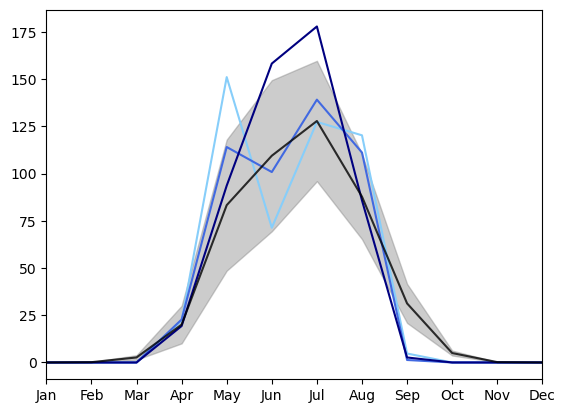

In [9]:
mons = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
coli = ['lightskyblue', 'royalblue', 'navy']

for yr in np.arange(0,3):
    plt.plot(mons[0:12], npp_sums[yr,:]/1e8, color = coli[yr])
    #1e8 is the correct conversion! 

plt.plot(mons[0:12], clim_arc[0:12], color = 'black', alpha = 0.8); #plt.xlabel('Month'), #plt.ylabel(unit)
plt.fill_between(mons[0:12],(clim_arc[0:12] - clim_arc_sd[0:12]), (clim_arc[0:12] + clim_arc_sd[0:12]), color = 'grey', alpha = 0.4)
plt.xlim(0,11)
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/validation.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()
